In [211]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML
from brian2.units import *
import matplotlib as mlib
from scipy import stats

In [282]:
mlib.rcParams.update({'font.size': 22})
mlib.rcParams.update({'errorbar.capsize': 3})

In [213]:
# data = np.load("D:/Work/Neurogenesis-PhD/simulation_statistics/batch_analysis_165611_07012018.npz")
data = np.load("D:/Work/Neurogenesis-PhD/simulation_statistics/batch_analysis_092030_10012018.npz")
print data['recording_archive_name']
# metadata = np.load("D:/Work/Neurogenesis-PhD/simulation_statistics/batch_2dd991bdb16f6d60bb4fad691d7d4169.npz")
metadata = np.load("D:/Work/Neurogenesis-PhD/simulation_statistics/batch_411ce53dcdd8abee141e53b8e2e6cfbe.npz")
print 'Total time taken for simulations:', metadata['total_time']
print metadata['log_calls'][0]

../synaptogenesis/411ce53dcdd8abee141e53b8e2e6cfbe/case1_inputtype4_lesiontype2_run9_@411ce53dcdd8abee141e53b8e2e6cfbe.npz
Total time taken for simulations: 1 day, 19:47:33.975627
['/home/bogdanp/PhD/phd_venv/bin/python' 'topographic_map_formation.py'
 '--case' '1' '-i'
 '../simulation_statistics/2009_09_04.17_48_33 32Syn300s/InitialConnectivity.mat'
 '-o' 'case1_inputtype1_lesiontype0_run1_@411ce53dcdd8abee141e53b8e2e6cfbe'
 '--no_iterations' '600000' '--t_record' '30000' '--input_type' '1'
 '--lesion' '0']


In [214]:
snapshots = data['snapshots']
params = data['params']
dt = np.dtype([('rate', 'float'), 
               ('number_ff_synapses', 'float'), 
               ('final_weight_proportion', 'float'), 
               ('init_mean_std', 'float'),
               ('fin_mean_std_conn_shuf', 'float'),
               ('fin_mean_std_conn', 'float'),
               ('wsr_sigma_fin_conn_fin_conn_shuffle', 'float'),
               ('fin_mean_std_weight_shuf', 'float'),
               ('fin_mean_std_weight', 'float'),
               ('wsr_sigma_fin_weight_fin_weight_shuffle', 'float'),
               ('init_mean_AD', 'float'),
               ('fin_mean_AD_conn_shuf', 'float'),
               ('fin_mean_AD_conn', 'float'),
               ('wsr_AD_fin_conn_fin_conn_shuffle', 'float'),
               ('fin_mean_AD_weight_shuf', 'float'),
               ('fin_mean_AD_weight', 'float'),
               ('wsr_AD_fin_weight_fin_weight_shuffle', 'float'),
#                ('file_path', 'S59')
              ])
results = np.array(data['results'][:, :-1], dtype=float)

parameters_of_interest = metadata['parameters_of_interest']
parameters_of_interest = parameters_of_interest.ravel()[0]

In [215]:
# These are all wrong (except case), parameters all are default
parameters_of_interest

{'cases': [1],
 'input_types': [1, 2, 3, 4],
 'lesion_types': [0, 1, 2],
 'no_runs': 10}

In [216]:
snapshots[10]

array([ array([ 2.87764014,  2.46546851,  2.29253643,  2.10460012,  1.98973933,
        1.9322693 ,  1.83343871,  1.75215488,  1.64348656,  1.61730801,
        1.55953504,  1.53005524,  1.50484014,  1.47564418,  1.44767793,
        1.43383257,  1.4092821 ,  1.39818343,  1.38092936,  1.37400438]),
       array([ 4.08231564,  3.2422699 ,  3.55580288,  2.94688061,  2.93375338,
        2.48745944,  1.97201782,  1.63275395,  1.47808204,  1.23795526,
        1.1767679 ,  1.13319738,  1.17496553,  1.08295278,  1.03214154,
        1.02185657,  1.02237021,  1.03219661,  0.96270527,  0.95374516]),
       array([ 3.49210584,  3.13457606,  2.82013388,  2.61706304,  2.45183578,
        2.35253362,  2.22591292,  2.11766619,  1.996567  ,  1.92143358,
        1.82125572,  1.75979582,  1.73497724,  1.70472549,  1.65471793,
        1.63316845,  1.60206881,  1.57978415,  1.58645099,  1.55786874]),
       array([ 3.94475929,  2.84397179,  2.41293683,  2.12478181,  1.91460519,
        1.78238994,  1.555360

In [217]:
results[120]

IndexError: index 120 is out of bounds for axis 0 with size 120

In [272]:
def get_id_of_params(input_type, lesion_type, case, params=params):
    ids = []
    for current_id, current_params in np.ndenumerate(params[:,0]):
        if np.logical_and(np.logical_and(current_params['input_type'] == input_type, 
                                         current_params['lesion']==lesion_type), 
                          current_params['case'] == case):
            ids.append(current_id[0])
    return ids
    
def generate_snapshot_statistics(ids, snapshots=snapshots):  
    all_mean_sigmas = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    all_mean_ADs = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    all_mean_sigmas_conn = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    all_mean_ADs_conn = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    
    for curr_id in range(len(ids)):
        all_mean_sigmas[curr_id, :] = np.append([results[ids[curr_id]][3]], snapshots[ids[curr_id]][0])
        assert np.isclose(results[ids[curr_id]][8], snapshots[ids[curr_id]][0][-1]), "{} vs. {}".format(results[ids[curr_id]][8], snapshots[ids[curr_id]][0][-1])
        all_mean_ADs[curr_id, :] = np.append([results[ids[curr_id]][10]], snapshots[ids[curr_id]][1])
        all_mean_sigmas_conn[curr_id, :] = np.append([results[ids[curr_id]][3]], snapshots[ids[curr_id]][2])
        assert np.isclose(results[ids[curr_id]][5], snapshots[ids[curr_id]][2][-1]), "{} vs. {}".format(results[ids[curr_id]][5], snapshots[ids[curr_id]][2][-1])
        all_mean_ADs_conn[curr_id, :] = np.append([results[ids[curr_id]][10]], snapshots[ids[curr_id]][3])
        
    mean_sigmas = np.mean(all_mean_sigmas, axis=0)
    mean_ADs = np.mean(all_mean_ADs, axis=0)
    mean_sigmas_conn = np.mean(all_mean_sigmas_conn, axis=0)
    mean_ADs_conn = np.mean(all_mean_ADs_conn, axis=0)
    
    std_sigmas = stats.sem(all_mean_sigmas, axis=0)
    std_ADs = stats.sem(all_mean_ADs, axis=0)
    std_sigmas_conn = stats.sem(all_mean_sigmas_conn, axis=0)
    std_ADs_conn = stats.sem(all_mean_ADs_conn, axis=0)
    
    
    log_std_sigmas = stats.sem(np.log(all_mean_sigmas), axis=0)
    log_std_ADs = stats.sem(np.log(all_mean_ADs), axis=0)
    log_std_sigmas_conn = stats.sem(np.log(all_mean_sigmas_conn), axis=0)
    log_std_ADs_conn = stats.sem(np.log(all_mean_ADs_conn), axis=0)
    
    return mean_sigmas, std_sigmas, \
           mean_ADs, std_ADs, \
           mean_sigmas_conn, std_sigmas_conn, \
           mean_ADs_conn, std_ADs_conn, \
           log_std_sigmas, log_std_ADs, log_std_sigmas_conn, log_std_ADs_conn

In [273]:
ids = get_id_of_params(input_type=1, lesion_type=0, case=1)
print ids

[0L, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L]


In [274]:
generate_snapshot_statistics(ids)

(array([ 2.35496906,  1.80634246,  1.72342855,  1.67053312,  1.62569853,
         1.58946131,  1.56229062,  1.52840777,  1.50443311,  1.48214991,
         1.46299587,  1.45124362,  1.44000881,  1.42488961,  1.41036925,
         1.40409644,  1.3908213 ,  1.3810502 ,  1.37249561,  1.35879627,
         1.34715238]),
 array([  1.48029737e-16,   3.84337100e-03,   3.08066951e-03,
          3.88902703e-03,   4.31170626e-03,   3.49844868e-03,
          4.62880701e-03,   5.35619795e-03,   3.03357670e-03,
          2.84943639e-03,   4.82299261e-03,   3.87921925e-03,
          2.66271515e-03,   3.63065739e-03,   3.74704213e-03,
          2.84381467e-03,   4.66131581e-03,   3.57381585e-03,
          4.10218533e-03,   2.75717421e-03,   2.33756296e-03]),
 array([ 0.81999251,  0.83525122,  0.8257708 ,  0.81169351,  0.81566764,
         0.8123745 ,  0.79896869,  0.79605016,  0.80076044,  0.80807426,
         0.81346299,  0.8166543 ,  0.82423471,  0.81875698,  0.82680027,
         0.82511076,  0.828186

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:25: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



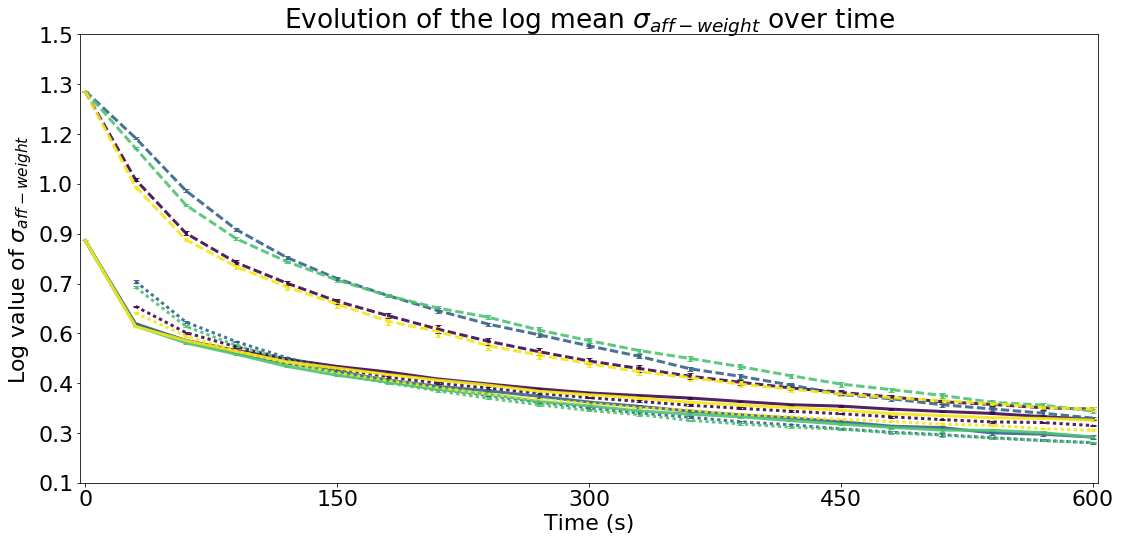

In [421]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
# conc_std_1 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_1, axis=0)))
# conc_std_2 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_2, axis=0)))
# conc_std_3 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_3, axis=0)))

# conc_std_1_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_1, axis=0)))
# conc_std_2_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_2, axis=0)))
# conc_std_3_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_3, axis=0)))


# i = \
# ax1.errorbar(np.arange(conc_std_1.size) * hardcoded_t_record, conc_std_1, conc_std_1_std, label='Mean $\sigma_{aff\_weight}$ case 1', alpha=.9, linewidth=3)
# ax1.errorbar(np.arange(conc_std_2.size) * hardcoded_t_record, conc_std_2, conc_std_2_std, label='Mean $\sigma_{aff\_weight}$ case 2', alpha=.7, linewidth=3)
# ax1.errorbar(np.arange(conc_std_3.size) * hardcoded_t_record, conc_std_3, conc_std_3_std, label='Mean $\sigma_{aff\_weight}$ case 3', alpha=.7, linewidth=3)
# ax1.plot(np.arange(all_mean_sigmas_case_3.size+1) * hardcoded_t_record, conc_case_3, label='Mean $\sigma_{aff}$ case 3 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--')
# ax1.plot(np.arange(all_mean_sigmas_case_1_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input, label='Mean $\sigma_{aff}$ case 1 non-lesioned Gaussian input', alpha=.7, linewidth=2, ls=':', c='k' )
# ax1.plot(np.arange(all_mean_sigmas_case_1_lesioned_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input_lesioned, label='Mean $\sigma_{aff}$ case 1 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--',c='b' )

for case in parameters_of_interest['cases']:
    for input_type, input_colour in zip(parameters_of_interest['input_types'], ['#3E0A4F', '#366488', '#4EC373', '#f3e718']):
        for lesion_type, lesion_ls in zip(parameters_of_interest['lesion_types'],['-', '--', ':']): 
            all_stats = generate_snapshot_statistics(get_id_of_params(input_type=input_type, lesion_type=lesion_type, case=case))
#             print all_stats
#             break
            _ = ax1.errorbar(np.arange(len(all_stats[0])) * hardcoded_t_record, np.log(all_stats[0]), all_stats[8], 
                             label='$\sigma_{aff\_weight}$ ' + 'case {} input {} lesion {}'.format(case, input_type, lesion_type),  
                             alpha=.9, linewidth=3,
                            linestyle=lesion_ls, color=input_colour)


ax1.grid(visible=False)
ax1.set_title("Evolution of the log mean $\sigma_{aff-weight}$ over time")
# ax1.set_ylim([0, np.max([conc_std_1, conc_std_2, conc_std_3]) + 0.2])
ax1.set_xlabel("Time (" + str(hardcoded_t_record.dimensions) + ")")
ax1.set_ylabel("Log value of $\sigma_{aff-weight}$")

# ax1.scatter(0, hardcoded_init_mean_std, marker='x', c='r', label="Initial mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.scatter(conc_std_1.size* hardcoded_t_record//2, 1.42, c='r', label="Final mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.set_ylim([0, 4.0])
# ax1.set_xlim([-1, 301])
# ax1.set_yscale("symlog", linthreshy=.0001)

# ax1.set_xticks([20, 200, 500])
ax1.get_yaxis().set_major_formatter(mlib.ticker.ScalarFormatter())

lspace = np.linspace(0.1, 1.5, 10)

ax1.set_yticks(lspace)
lspacelabels = []
for value in lspace:
    lspacelabels.append("{:1.1f}".format(value))
ax1.set_yticklabels(lspacelabels)

ax1.set_xticks([0, 150, 300, 450, 600])
ax1.set_xlim([-3, 603])

# ax1.legend(loc='upper right')
plt.tight_layout()
plt.savefig("log_mean_std_evo_with_errorbars_different_inputs_lesions_cases_runs.png")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



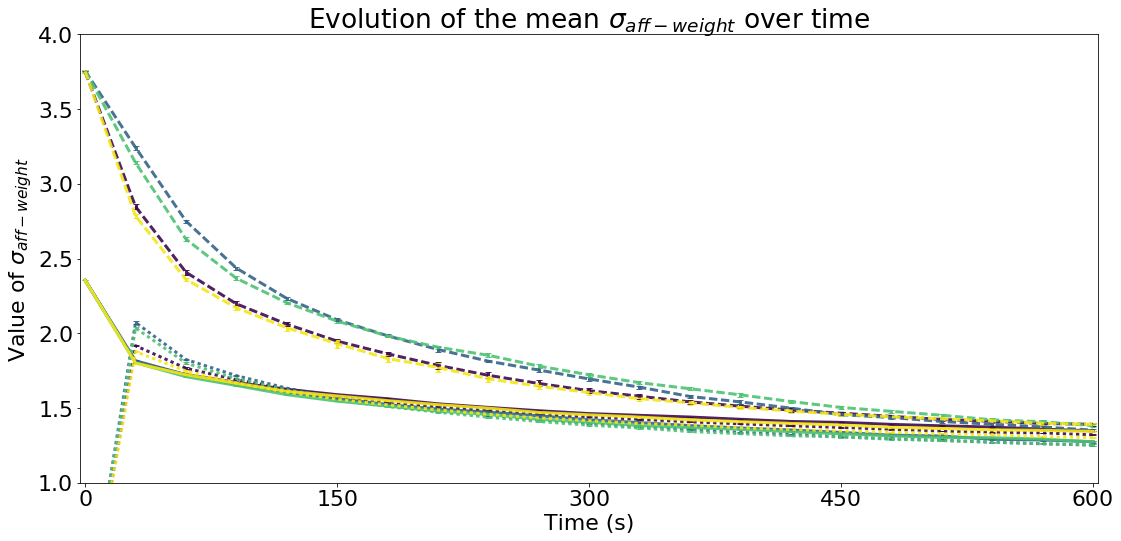

In [427]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
# conc_std_1 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_1, axis=0)))
# conc_std_2 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_2, axis=0)))
# conc_std_3 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_3, axis=0)))

# conc_std_1_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_1, axis=0)))
# conc_std_2_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_2, axis=0)))
# conc_std_3_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_3, axis=0)))


# i = \
# ax1.errorbar(np.arange(conc_std_1.size) * hardcoded_t_record, conc_std_1, conc_std_1_std, label='Mean $\sigma_{aff\_weight}$ case 1', alpha=.9, linewidth=3)
# ax1.errorbar(np.arange(conc_std_2.size) * hardcoded_t_record, conc_std_2, conc_std_2_std, label='Mean $\sigma_{aff\_weight}$ case 2', alpha=.7, linewidth=3)
# ax1.errorbar(np.arange(conc_std_3.size) * hardcoded_t_record, conc_std_3, conc_std_3_std, label='Mean $\sigma_{aff\_weight}$ case 3', alpha=.7, linewidth=3)
# ax1.plot(np.arange(all_mean_sigmas_case_3.size+1) * hardcoded_t_record, conc_case_3, label='Mean $\sigma_{aff}$ case 3 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--')
# ax1.plot(np.arange(all_mean_sigmas_case_1_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input, label='Mean $\sigma_{aff}$ case 1 non-lesioned Gaussian input', alpha=.7, linewidth=2, ls=':', c='k' )
# ax1.plot(np.arange(all_mean_sigmas_case_1_lesioned_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input_lesioned, label='Mean $\sigma_{aff}$ case 1 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--',c='b' )

lines = []
labels= []

for case in parameters_of_interest['cases']:
    for input_type, input_colour in zip(parameters_of_interest['input_types'], ['#3E0A4F', '#366488', '#4EC373', '#f3e718']):
        for lesion_type, lesion_ls in zip(parameters_of_interest['lesion_types'],['-', '--', ':']): 
            all_stats = generate_snapshot_statistics(get_id_of_params(input_type=input_type, lesion_type=lesion_type, case=case))
            l = r'$\mathrm{AD}$ ' + 'case {} input {} lesion {}'.format(case, input_type, lesion_type)
            labels.append(l)
            lines.append(ax1.errorbar(np.arange(len(all_stats[0])) * hardcoded_t_record, all_stats[0], all_stats[1], 
                             label=l, 
                             alpha=.9, linewidth=3,
                            linestyle=lesion_ls, color=input_colour)
                         )
            


ax1.grid(visible=False)
ax1.set_title("Evolution of the mean $\sigma_{aff-weight}$ over time")
# ax1.set_ylim([0, np.max([conc_std_1, conc_std_2, conc_std_3]) + 0.2])
ax1.set_xlabel("Time (" + str(hardcoded_t_record.dimensions) + ")")
ax1.set_ylabel("Value of $\sigma_{aff-weight}$")


# ax1.set_yscale("log")
# ax1.set_xticks([20, 200, 500])
# ax1.get_yaxis().set_major_formatter(mlib.ticker.ScalarFormatter())
# ax1.set_yticks(np.arange(1,7))

ax1.set_xticks([0, 150, 300, 450, 600])
ax1.set_xlim([-3, 603])
# ax1.scatter(0, hardcoded_init_mean_std, marker='x', c='r', label="Initial mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.scatter(conc_std_1.size* hardcoded_t_record//2, 1.42, c='r', label="Final mean $\sigma_{aff}$ in the original, non-lesioned case")
ax1.set_ylim([1., 4.0])
# ax1.set_xlim([-1, 301])

# f.legend(lines,l, loc='right', ncol=2)
plt.tight_layout()
plt.savefig("mean_std_evo_with_errorbars_different_inputs_lesions_cases_runs.png")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



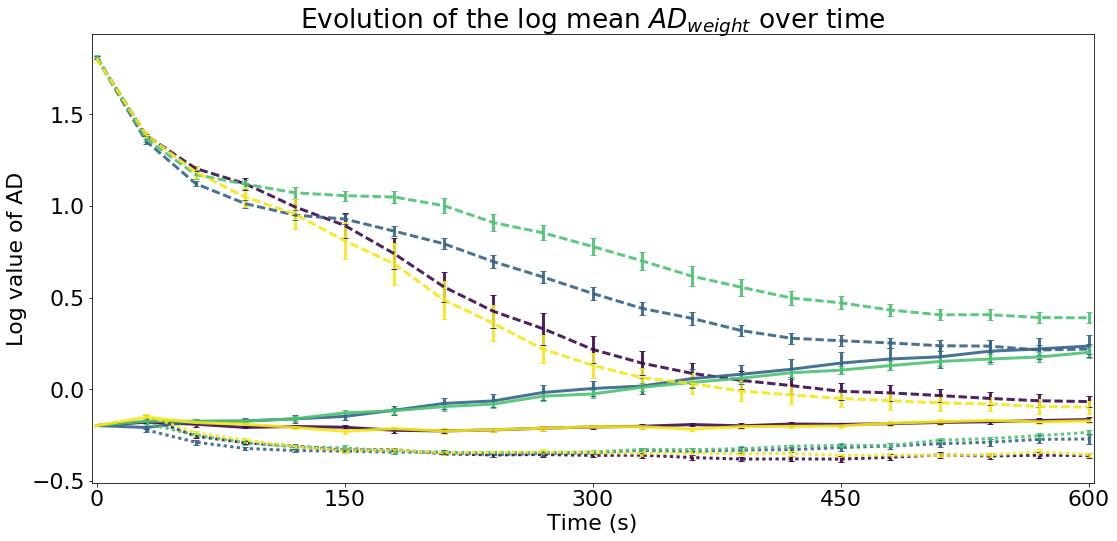

In [420]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
# conc_std_1 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_1, axis=0)))
# conc_std_2 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_2, axis=0)))
# conc_std_3 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_3, axis=0)))

# conc_std_1_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_1, axis=0)))
# conc_std_2_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_2, axis=0)))
# conc_std_3_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_3, axis=0)))


# i = \
# ax1.errorbar(np.arange(conc_std_1.size) * hardcoded_t_record, conc_std_1, conc_std_1_std, label='Mean $\sigma_{aff\_weight}$ case 1', alpha=.9, linewidth=3)
# ax1.errorbar(np.arange(conc_std_2.size) * hardcoded_t_record, conc_std_2, conc_std_2_std, label='Mean $\sigma_{aff\_weight}$ case 2', alpha=.7, linewidth=3)
# ax1.errorbar(np.arange(conc_std_3.size) * hardcoded_t_record, conc_std_3, conc_std_3_std, label='Mean $\sigma_{aff\_weight}$ case 3', alpha=.7, linewidth=3)
# ax1.plot(np.arange(all_mean_sigmas_case_3.size+1) * hardcoded_t_record, conc_case_3, label='Mean $\sigma_{aff}$ case 3 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--')
# ax1.plot(np.arange(all_mean_sigmas_case_1_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input, label='Mean $\sigma_{aff}$ case 1 non-lesioned Gaussian input', alpha=.7, linewidth=2, ls=':', c='k' )
# ax1.plot(np.arange(all_mean_sigmas_case_1_lesioned_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input_lesioned, label='Mean $\sigma_{aff}$ case 1 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--',c='b' )

lines = []
labels= []

for case in parameters_of_interest['cases']:
    for input_type, input_colour in zip(parameters_of_interest['input_types'], ['#3E0A4F', '#366488', '#4EC373', '#f3e718']):
        for lesion_type, lesion_ls in zip(parameters_of_interest['lesion_types'],['-', '--', ':']): 
            all_stats = generate_snapshot_statistics(get_id_of_params(input_type=input_type, lesion_type=lesion_type, case=case))
            l = r'$\mathrm{AD}$ ' + 'case {} input {} lesion {}'.format(case, input_type, lesion_type)
            labels.append(l)
            lines.append(ax1.errorbar(np.arange(len(all_stats[2])) * hardcoded_t_record, np.log(all_stats[2]), all_stats[9], 
                             label=l, 
                             alpha=.9, linewidth=3,
                            linestyle=lesion_ls, color=input_colour)
                         )
            


ax1.grid(visible=False)
ax1.set_title("Evolution of the log mean $AD_{weight}$ over time")
# ax1.set_ylim([0, np.max([conc_std_1, conc_std_2, conc_std_3]) + 0.2])
ax1.set_xlabel("Time (" + str(hardcoded_t_record.dimensions) + ")")
ax1.set_ylabel("Log value of AD")


# ax1.set_yscale("symlog", linthreshx=.001)
# ax1.set_xticks([20, 200, 500])
# ax1.get_yaxis().set_major_formatter(mlib.ticker.ScalarFormatter())
# ax1.set_yticks(np.arange(-.5,3))

ax1.set_xticks([0, 150, 300, 450, 600])
ax1.set_xlim([-3, 603])
# ax1.scatter(0, hardcoded_init_mean_std, marker='x', c='r', label="Initial mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.scatter(conc_std_1.size* hardcoded_t_record//2, 1.42, c='r', label="Final mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.set_ylim([0, 4.0])
# ax1.set_xlim([-1, 301])
# ax1.set_ylim([-1, 2])
# f.legend(lines,l, loc='right', ncol=2)
plt.tight_layout()
plt.savefig("log_mean_ad_evo_with_errorbars_different_inputs_lesions_cases_runs.png")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



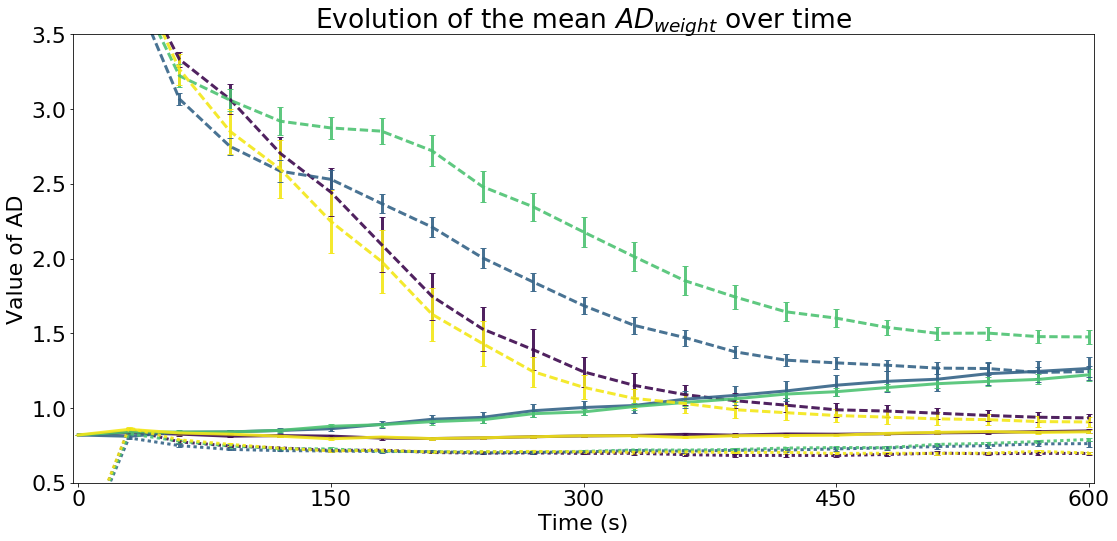

In [426]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
# conc_std_1 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_1, axis=0)))
# conc_std_2 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_2, axis=0)))
# conc_std_3 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_3, axis=0)))

# conc_std_1_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_1, axis=0)))
# conc_std_2_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_2, axis=0)))
# conc_std_3_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_3, axis=0)))


# i = \
# ax1.errorbar(np.arange(conc_std_1.size) * hardcoded_t_record, conc_std_1, conc_std_1_std, label='Mean $\sigma_{aff\_weight}$ case 1', alpha=.9, linewidth=3)
# ax1.errorbar(np.arange(conc_std_2.size) * hardcoded_t_record, conc_std_2, conc_std_2_std, label='Mean $\sigma_{aff\_weight}$ case 2', alpha=.7, linewidth=3)
# ax1.errorbar(np.arange(conc_std_3.size) * hardcoded_t_record, conc_std_3, conc_std_3_std, label='Mean $\sigma_{aff\_weight}$ case 3', alpha=.7, linewidth=3)
# ax1.plot(np.arange(all_mean_sigmas_case_3.size+1) * hardcoded_t_record, conc_case_3, label='Mean $\sigma_{aff}$ case 3 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--')
# ax1.plot(np.arange(all_mean_sigmas_case_1_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input, label='Mean $\sigma_{aff}$ case 1 non-lesioned Gaussian input', alpha=.7, linewidth=2, ls=':', c='k' )
# ax1.plot(np.arange(all_mean_sigmas_case_1_lesioned_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input_lesioned, label='Mean $\sigma_{aff}$ case 1 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--',c='b' )

lines = []
labels= []

input_text = ["Gaussian", "Pointy", "Scaled Pointy", "Square"]
lesion_text = ["initial connectivity", "no initial connectivity", "random initial connectivity"]

for case in parameters_of_interest['cases']:
    for input_type, input_colour in zip(parameters_of_interest['input_types'], ['#3E0A4F', '#366488', '#4EC373', '#f3e718']):
        for lesion_type, lesion_ls in zip(parameters_of_interest['lesion_types'],['-', '--', ':']): 
            all_stats = generate_snapshot_statistics(get_id_of_params(input_type=input_type, lesion_type=lesion_type, case=case))
            l = '{} input starting with {}'.format(input_text[input_type-1], lesion_text[lesion_type])
            labels.append(l)
            lines.append(ax1.errorbar(np.arange(len(all_stats[2])) * hardcoded_t_record, all_stats[2], all_stats[3], 
                             label=l, 
                             alpha=.9, linewidth=3,
                            linestyle=lesion_ls, color=input_colour)
                         )
            


ax1.grid(visible=False)
ax1.set_title("Evolution of the mean $AD_{weight}$ over time")
# ax1.set_ylim([0, np.max([conc_std_1, conc_std_2, conc_std_3]) + 0.2])
ax1.set_xlabel("Time (" + str(hardcoded_t_record.dimensions) + ")")
ax1.set_ylabel("Value of AD")


# ax1.set_yscale("log")
# ax1.set_xticks([20, 200, 500])
# ax1.get_yaxis().set_major_formatter(mlib.ticker.ScalarFormatter())
# ax1.set_yticks(np.arange(1,7))

ax1.set_xticks([0, 150, 300, 450, 600])
ax1.set_xlim([-3, 603])
# ax1.scatter(0, hardcoded_init_mean_std, marker='x', c='r', label="Initial mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.scatter(conc_std_1.size* hardcoded_t_record//2, 1.42, c='r', label="Final mean $\sigma_{aff}$ in the original, non-lesioned case")
ax1.set_ylim([0.5, 3.5])
# ax1.set_xlim([-1, 301])

# f.legend(lines,l, loc='right', ncol=2)
plt.tight_layout()
plt.savefig("mean_ad_evo_with_errorbars_different_inputs_lesions_cases_runs.png")
plt.show()

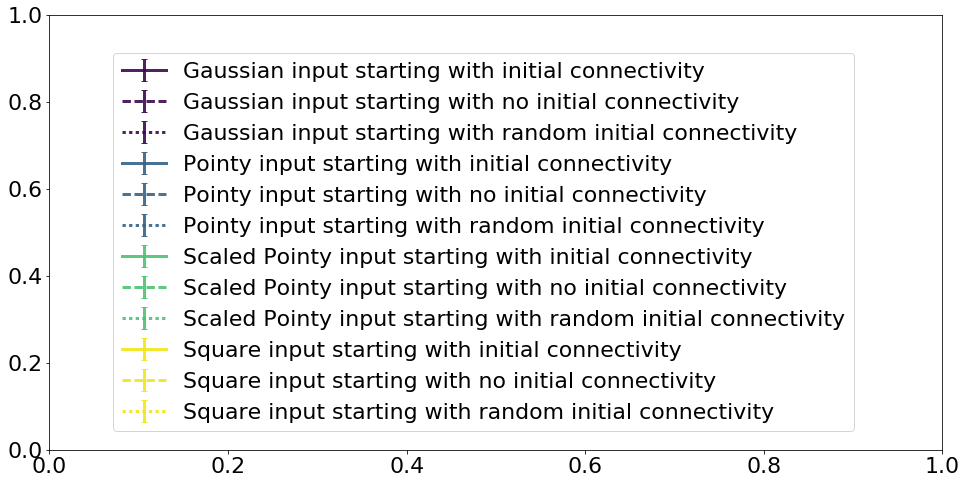

In [413]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
f.legend(lines,labels, loc='center', ncol=1)
plt.savefig("legend.png")

In [335]:
np.log(all_stats[2])

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
 [py.warnings]
  if __name__ == '__main__':



array([       -inf, -0.14297367, -0.23872611, -0.27830558, -0.3130913 ,
       -0.33745374, -0.33226969, -0.3476648 , -0.34560147, -0.34284623,
       -0.34584412, -0.35052286, -0.34835365, -0.35257243, -0.35097064,
       -0.36163569, -0.35962961, -0.36112767, -0.35825835, -0.34298126,
       -0.35701389])

# Let's report some average numbers

In [150]:
rates_case_1 = results[0:10, 0]
rates_case_2 = results[10:20, 0]
rates_case_3 = results[20:30, 0]

final_number_of_syn_case_1 = results[0:10, 1]
final_number_of_syn_case_2 = results[10:20, 1]
final_number_of_syn_case_3 = results[20:30, 1]

weight_proportion_case_1 = results[0:10, 2]
weight_proportion_case_2 = results[10:20, 2]
weight_proportion_case_3 = results[20:30, 2]

p_sigma_aff_conn_case_1 = results[0:10, 6]
p_sigma_aff_conn_case_2 = results[10:20, 6]
p_sigma_aff_conn_case_3 = results[20:30, 6]

p_sigma_aff_weight_case_1 = results[0:10, 9]
p_sigma_aff_weight_case_2 = results[10:20, 9]
p_sigma_aff_weight_case_3 = results[20:30, 9]

p_ad_conn_case_1 = results[0:10, 13]
p_ad_conn_case_2 = results[10:20, 13]
p_ad_conn_case_3 = results[20:30, 13]

p_ad_weight_case_1 = results[0:10, 16]
p_ad_weight_case_2 = results[10:20, 16]
p_ad_weight_case_3 = results[20:30, 16]

In [143]:
print "rates"
print np.mean(rates_case_1), stats.scoreatpercentile(rates_case_1, 95)
print np.mean(rates_case_2), stats.scoreatpercentile(rates_case_2, 95)
print np.mean(rates_case_3), stats.scoreatpercentile(rates_case_3, 95) 

rates
21.1355716146 21.2310944011
20.0807877604 20.1449492187
9.37506640625 9.48626171875


In [149]:
print "final_number_of_syn"
print np.mean(final_number_of_syn_case_1), stats.scoreatpercentile(final_number_of_syn_case_1, 95)
print np.mean(final_number_of_syn_case_2), stats.scoreatpercentile(final_number_of_syn_case_2, 95)
print np.mean(final_number_of_syn_case_3), stats.scoreatpercentile(final_number_of_syn_case_3, 95) 

final_number_of_syn
15.8015625 15.9845703125
16.0 16.0
11.897265625 12.05234375


In [151]:
print "weight_proportion"
print np.mean(weight_proportion_case_1), stats.scoreatpercentile(weight_proportion_case_1, 95)
print np.mean(weight_proportion_case_2), stats.scoreatpercentile(weight_proportion_case_2, 95)
print np.mean(weight_proportion_case_3), stats.scoreatpercentile(weight_proportion_case_3, 95) 

weight_proportion
0.828067183224 0.838854271955
0.709332168102 0.723161369562
0.607832549803 0.622256648146


In [144]:
print "p_ad_conn"
print np.mean(p_ad_conn_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_conn_case_1, 95)
print np.mean(p_ad_conn_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_conn_case_2, 95)
print np.mean(p_ad_conn_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_conn_case_3, 95)

p_ad_conn
10.0 % 0.480281685054
0.0 % 0.85085102503
0.0 % 0.69163492977


In [145]:
print "p_ad_weight"
print np.mean(p_ad_weight_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_weight_case_1, 95)
print np.mean(p_ad_weight_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_weight_case_2, 95)
print np.mean(p_ad_weight_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_weight_case_3, 95)

p_ad_weight
50.0 % 0.586598678511
70.0 % 0.189788101393
10.0 % 0.849346251479


In [147]:
print "p_sigma_aff_conn"
print np.mean(p_sigma_aff_conn_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_conn_case_1, 95)
print np.mean(p_sigma_aff_conn_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_conn_case_2, 95)
print np.mean(p_sigma_aff_conn_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_conn_case_3, 95)

p_sigma_aff_conn
100.0 % 4.24289202912e-42
0.0 % 0.989538257019
100.0 % 6.52508403983e-15


In [148]:
print "p_sigma_aff_weight"
print np.mean(p_sigma_aff_weight_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_weight_case_1, 95)
print np.mean(p_sigma_aff_weight_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_weight_case_2, 95)
print np.mean(p_sigma_aff_weight_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_weight_case_3, 95)

p_sigma_aff_weight
100.0 % 1.97177599148e-32
100.0 % 2.86099086389e-43
100.0 % 2.18620835771e-17
